Importing

In [27]:
import torch
from torch.optim import Adam
from torch.optim import LBFGS
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
from IPython.display import HTML
import copy
import seaborn as sns
sns.set_style('darkgrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load Model Params

In [28]:
MODEL_NAME = "2D_Isotropic_Beam_5.08E-04_5048"
LOAD_PATH = "Models\\" + MODEL_NAME + ".tar"
checkpoint = torch.load(LOAD_PATH, map_location=device)
params_in, params_out, i_num, i_len = checkpoint['model_params']

Plotting Range

In [29]:
def grid(x,y,nx,ny):
    grid_arr = list()
    xs = torch.linspace(0,x,nx)
    ys = torch.linspace(0,y,ny)
    for x in xs:
        for y in ys:
            grid_arr.append((x.item(),y.item()))
    grid_arr = torch.tensor(grid_arr)
    return grid_arr

plotting = grid(10,10,20,20).requires_grad_(True).to(device)

In [30]:
# fn to create model
def pinn(input_size, output_size, num_layers, nodes_per_layer, activation):
    layers = []
    
    # Input layer
    layers.append(nn.Linear(input_size, nodes_per_layer))
    
    # Hidden layers
    for layer in range(num_layers):
        layers.append(nn.Linear(nodes_per_layer, nodes_per_layer))
        if layer == 0 and activation==Siren:
            layers.append(activation(l=0))
        else:
            layers.append(activation())
    
    # Output layer
    layers.append(nn.Linear(nodes_per_layer, output_size))
    
    return nn.Sequential(*layers)


# custom trainable Tanh activation fn
class TTanh(nn.Module):
    def __init__(self, features=i_len):
        super().__init__()
        self.features = features
        self.a = nn.Parameter(torch.randn(1, features))
        
    def forward(self, x):
        return torch.tanh(self.a * x)

#custom SIREN activation fn
class Siren(nn.Module):
    def __init__(self, features=i_len, l=1):
        super(Siren, self).__init__()
        self.features = features
        # Learnable parameters for the phase and bias
        if l: w = 1 
        else: w = 30
        n = torch.sqrt(torch.tensor(6.0/features))
        self.a_weight = nn.Parameter((torch.rand(1, features) *2*n - n)*w)
        self.a_bias = nn.Parameter(torch.randn(1, features))

    def forward(self, x):
        # Apply the periodic activation function
        return torch.sin( self.a_weight*x + self.a_bias)

In [31]:
model = pinn(params_in, params_out, i_num, i_len, TTanh)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=64, bias=True)
  (2): TTanh()
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): TTanh()
  (5): Linear(in_features=64, out_features=2, bias=True)
)

Solution

In [32]:
#sol?

Creating Position and Displacement Array

In [33]:
model_pred = list()
for i in range(len(plotting)):
    #x,y,dx,dy
    pred = model(plotting[i])
    model_pred.append([plotting[i][0].item(), plotting[i][1].item(), pred[:,0].item(), pred[:,1].item()])
model_pred = np.array(model_pred)
LOAD_PATH = "Plot_Data\\" + MODEL_NAME + ".csv"
np.savetxt(LOAD_PATH, model_pred, delimiter=",")

Anim with Matplotlib

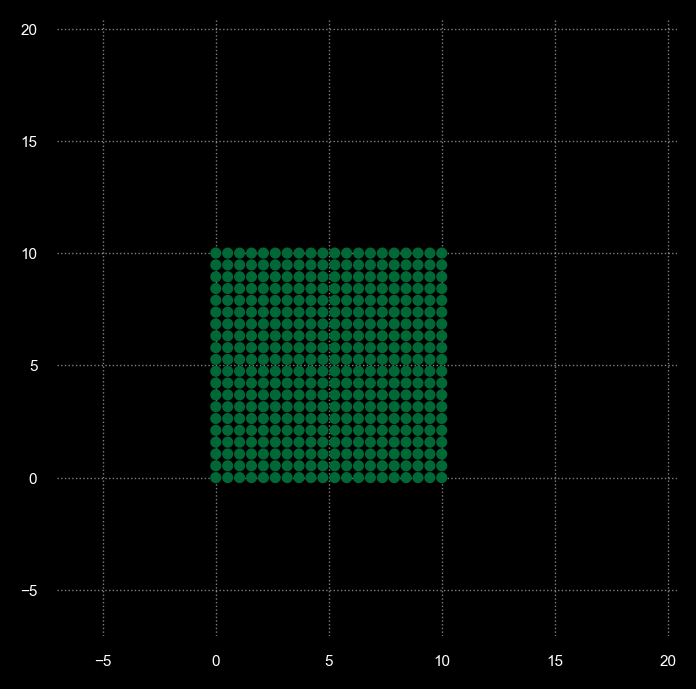

In [34]:
# obtaining plot range
plotting = grid(10,10,20,20).requires_grad_(True).to(device)
max_disp = 0

# obtaining plot data
model_pred = list()
for i in range(len(plotting)):
    #x,y,dx,dy
    pred = model(plotting[i])
    model_pred.append([plotting[i][0].item(), plotting[i][1].item(), pred[:,0].item(), pred[:,1].item()])
    if (np.sqrt(pred[:,0].item()**2 + pred[:,1].item()**2) > max_disp): max_disp = np.sqrt(pred[:,0].item()**2 + pred[:,1].item()**2)
model_pred = np.array(model_pred)

#setting up figure
fig, ax = plt.subplots(1,1,figsize=(4,4),dpi=200)
[ax.spines[side].set_visible(False) for side in ax.spines]
fig.set_facecolor("black")
ax.set_facecolor("black")
ax.tick_params(axis='both', colors='white', labelsize=5.5, grid_color='white', grid_alpha=0.5, grid_linewidth=0.5, grid_linestyle=':')
cmap = plt.get_cmap('RdYlGn_r')

#setting limits
init = model_pred[:,0:2]
disp = model_pred[:,0:2] + model_pred[:,2:]
buffer = 0.4

def anim_update(a):
    ax.clear()
    norm_disp = np.sqrt(model_pred[:,2]**2+model_pred[:,3]**2)*a/max_disp
    ax.scatter((model_pred[:,0] + a*model_pred[:,2]).T,(model_pred[:,1] + a*model_pred[:,3]).T,marker='.',c=cmap(norm_disp))
    ax.set_xlim([np.min(np.vstack([init, disp])) - buffer, np.max(np.vstack([init, disp])) + buffer])
    ax.set_ylim([np.min(np.vstack([init, disp])) - buffer, np.max(np.vstack([init, disp])) + buffer])
    return None    

anim = animation.FuncAnimation(fig, anim_update, frames=np.linspace(0,1,100), interval=25)
HTML(anim.to_html5_video())